# Method 9 - Rest Ideas After 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

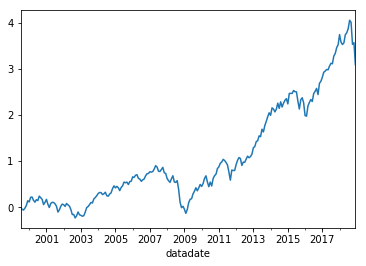

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.141499
2000-12-31   -0.031492
2001-12-31   -0.034699
2002-12-31   -0.215632
2003-12-31    0.491910
2004-12-31    0.171669
2005-12-31    0.069217
2006-12-31    0.107825
2007-12-31   -0.000047
2008-12-31   -0.411012
2009-12-31    0.463779
2010-12-31    0.230821
2011-12-31   -0.022877
2012-12-31    0.195956
2013-12-31    0.418289
2014-12-31    0.101057
2015-12-31   -0.027285
2016-12-31    0.143188
2017-12-31    0.212492
2018-12-31   -0.095662
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2834.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.07e-193
Time:                        21:09:54   Log-Likelihood:                 825.57
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     229   BIC:                            -1624.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.000      4.781      0.000       0.001       0.003
mktrf          1.0193      0.013     76.101      0.000       0.993       1.046
me             0.3015      0.016     19.348      0.000       0.271       0.332
ia             0.0745      0.024      3.145      0.002       0.028       0.121
roe           -0.1128      0.020     -5.567      0.000      -0.153      -0.073
==============================================================================
Omnibus:                       28.283   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.684
Skew:                          -0.022   Prob(JB):                     2.11e-35
Kurtosis:                       7.047   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2061.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.03e-178
Time:                        21:09:54   Log-Likelihood:                 825.57
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     229   BIC:                            -1624.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.462      0.000       0.001       0.003
mktrf          1.0193      0.016     65.329      0.000       0.989       1.050
me             0.3015      0.028     10.636      0.000       0.246       0.357
ia             0.0745      0.044      1.678      0.093      -0.013       0.161
roe           -0.1128      0.032     -3.505      0.000      -0.176      -0.050
==============================================================================
Omnibus:                       28.283   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.684
Skew:                          -0.022   Prob(JB):                     2.11e-35
Kurtosis:                       7.047   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2559.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-188
Time:                        21:09:54   Log-Likelihood:                 825.57
No. Observations:                 234   AIC:                            -1641.
Df Residuals:                     229   BIC:                            -1624.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.487      0.000       0.001       0.003
mktrf          1.0193      0.015     65.895      0.000       0.989       1.050
me             0.3015      0.028     10.713      0.000       0.246       0.357
ia             0.0745      0.045      1.638      0.101      -0.015       0.164
roe           -0.1128      0.036     -3.153      0.002      -0.183      -0.043
==============================================================================
Omnibus:                       28.283   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.684
Skew:                          -0.022   Prob(JB):                     2.11e-35
Kurtosis:                       7.047   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1853.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.17e-182
Time:                        21:09:54   Log-Likelihood:                 802.99
No. Observations:                 234   AIC:                            -1594.
Df Residuals:                     228   BIC:                            -1573.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.542      0.000       0.001       0.003
mktrf          1.0439      0.015     70.470      0.000       1.015       1.073
smb            0.3357      0.020     17.173      0.000       0.297       0.374
hml            0.0376      0.023      1.632      0.104      -0.008       0.083
rmw           -0.0644      0.026     -2.471      0.014      -0.116      -0.013
cma            0.0507      0.033      1.530      0.127      -0.015       0.116
==============================================================================
Omnibus:                       35.453   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.477
Skew:                           0.338   Prob(JB):                     6.54e-45
Kurtosis:                       7.518   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1539.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.97e-173
Time:                        21:09:54   Log-Likelihood:                 802.99
No. Observations:                 234   AIC:                            -1594.
Df Residuals:                     228   BIC:                            -1573.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.355      0.001       0.001       0.003
mktrf          1.0439      0.017     61.510      0.000       1.011       1.077
smb            0.3357      0.028     11.871      0.000       0.280       0.391
hml            0.0376      0.049      0.770      0.441      -0.058       0.133
rmw           -0.0644      0.034     -1.890      0.059      -0.131       0.002
cma            0.0507      0.045      1.118      0.264      -0.038       0.140
==============================================================================
Omnibus:                       35.453   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.477
Skew:                           0.338   Prob(JB):                     6.54e-45
Kurtosis:                       7.518   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2033.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.04e-187
Time:                        21:09:54   Log-Likelihood:                 802.99
No. Observations:                 234   AIC:                            -1594.
Df Residuals:                     228   BIC:                            -1573.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.206      0.001       0.001       0.003
mktrf          1.0439      0.017     62.895      0.000       1.011       1.076
smb            0.3357      0.028     12.106      0.000       0.281       0.390
hml            0.0376      0.049      0.767      0.443      -0.058       0.134
rmw           -0.0644      0.038     -1.677      0.094      -0.140       0.011
cma            0.0507      0.043      1.184      0.236      -0.033       0.135
==============================================================================
Omnibus:                       35.453   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.477
Skew:                           0.338   Prob(JB):                     6.54e-45
Kurtosis:                       7.518   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2207.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.53e-181
Time:                        21:09:54   Log-Likelihood:                 796.96
No. Observations:                 234   AIC:                            -1584.
Df Residuals:                     229   BIC:                            -1567.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.881      0.000       0.001       0.003
mktrf          1.0311      0.014     73.986      0.000       1.004       1.059
smb            0.3558      0.017     20.451      0.000       0.321       0.390
hml            0.0926      0.017      5.360      0.000       0.059       0.127
umd           -0.0511      0.011     -4.511      0.000      -0.073      -0.029
==============================================================================
Omnibus:                       25.140   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.537
Skew:                           0.154   Prob(JB):                     3.66e-25
Kurtosis:                       6.383   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1928.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.26e-175
Time:                        21:09:54   Log-Likelihood:                 796.96
No. Observations:                 234   AIC:                            -1584.
Df Residuals:                     229   BIC:                            -1567.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.208      0.001       0.001       0.003
mktrf          1.0311      0.018     57.136      0.000       0.996       1.066
smb            0.3558      0.024     15.041      0.000       0.309       0.402
hml            0.0926      0.048      1.947      0.052      -0.001       0.186
umd           -0.0511      0.022     -2.368      0.018      -0.093      -0.009
==============================================================================
Omnibus:                       25.140   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.537
Skew:                           0.154   Prob(JB):                     3.66e-25
Kurtosis:                       6.383   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2416.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.22e-186
Time:                        21:09:54   Log-Likelihood:                 796.96
No. Observations:                 234   AIC:                            -1584.
Df Residuals:                     229   BIC:                            -1567.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.070      0.002       0.001       0.003
mktrf          1.0311      0.015     66.896      0.000       1.001       1.061
smb            0.3558      0.025     14.268      0.000       0.307       0.405
hml            0.0926      0.052      1.768      0.077      -0.010       0.195
umd           -0.0511      0.018     -2.905      0.004      -0.086      -0.017
==============================================================================
Omnibus:                       25.140   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.537
Skew:                           0.154   Prob(JB):                     3.66e-25
Kurtosis:                       6.383   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1265.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.99e-94
Time:                        21:09:55   Log-Likelihood:                 403.61
No. Observations:                 120   AIC:                            -797.2
Df Residuals:                     115   BIC:                            -783.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.886      0.000       0.002       0.005
mktrf          1.0201      0.022     46.257      0.000       0.976       1.064
me             0.2770      0.022     12.716      0.000       0.234       0.320
ia             0.1177      0.034      3.450      0.001       0.050       0.185
roe           -0.1246      0.030     -4.129      0.000      -0.184      -0.065
==============================================================================
Omnibus:                       10.494   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.313
Skew:                          -0.074   Prob(JB):                     1.93e-06
Kurtosis:                       5.289   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1260.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.29e-94
Time:                        21:09:55   Log-Likelihood:                 403.61
No. Observations:                 120   AIC:                            -797.2
Df Residuals:                     115   BIC:                            -783.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.567      0.000       0.001       0.005
mktrf          1.0201      0.025     40.314      0.000       0.971       1.070
me             0.2770      0.030      9.273      0.000       0.218       0.336
ia             0.1177      0.048      2.428      0.015       0.023       0.213
roe           -0.1246      0.039     -3.184      0.001      -0.201      -0.048
==============================================================================
Omnibus:                       10.494   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.313
Skew:                          -0.074   Prob(JB):                     1.93e-06
Kurtosis:                       5.289   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2188.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.79e-107
Time:                        21:09:55   Log-Likelihood:                 403.61
No. Observations:                 120   AIC:                            -797.2
Df Residuals:                     115   BIC:                            -783.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.451      0.001       0.001       0.005
mktrf          1.0201      0.023     44.586      0.000       0.975       1.065
me             0.2770      0.031      9.031      0.000       0.217       0.337
ia             0.1177      0.043      2.751      0.006       0.034       0.202
roe           -0.1246      0.042     -2.968      0.003      -0.207      -0.042
==============================================================================
Omnibus:                       10.494   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.313
Skew:                          -0.074   Prob(JB):                     1.93e-06
Kurtosis:                       5.289   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     799.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.84e-87
Time:                        21:09:55   Log-Likelihood:                 390.30
No. Observations:                 120   AIC:                            -768.6
Df Residuals:                     114   BIC:                            -751.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.465      0.001       0.001       0.005
mktrf          1.0832      0.026     41.507      0.000       1.032       1.135
smb            0.3305      0.030     11.180      0.000       0.272       0.389
hml            0.0177      0.036      0.490      0.625      -0.054       0.089
rmw           -0.0351      0.043     -0.821      0.413      -0.120       0.050
cma            0.1148      0.047      2.453      0.016       0.022       0.207
==============================================================================
Omnibus:                       14.683   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               50.487
Skew:                           0.144   Prob(JB):                     1.09e-11
Kurtosis:                       6.165   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     959.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.27e-91
Time:                        21:09:55   Log-Likelihood:                 390.30
No. Observations:                 120   AIC:                            -768.6
Df Residuals:                     114   BIC:                            -751.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.344      0.001       0.001       0.005
mktrf          1.0832      0.033     33.163      0.000       1.019       1.147
smb            0.3305      0.042      7.926      0.000       0.249       0.412
hml            0.0177      0.081      0.220      0.826      -0.140       0.176
rmw           -0.0351      0.063     -0.554      0.580      -0.159       0.089
cma            0.1148      0.053      2.175      0.030       0.011       0.218
==============================================================================
Omnibus:                       14.683   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               50.487
Skew:                           0.144   Prob(JB):                     1.09e-11
Kurtosis:                       6.165   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1602.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.03e-104
Time:                        21:09:55   Log-Likelihood:                 390.30
No. Observations:                 120   AIC:                            -768.6
Df Residuals:                     114   BIC:                            -751.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.312      0.001       0.001       0.005
mktrf          1.0832      0.032     34.283      0.000       1.021       1.145
smb            0.3305      0.042      7.865      0.000       0.248       0.413
hml            0.0177      0.083      0.213      0.832      -0.146       0.181
rmw           -0.0351      0.070     -0.500      0.617      -0.173       0.102
cma            0.1148      0.049      2.349      0.019       0.019       0.211
==============================================================================
Omnibus:                       14.683   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               50.487
Skew:                           0.144   Prob(JB):                     1.09e-11
Kurtosis:                       6.165   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     938.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.18e-87
Time:                        21:09:55   Log-Likelihood:                 386.15
No. Observations:                 120   AIC:                            -762.3
Df Residuals:                     115   BIC:                            -748.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.855      0.000       0.002       0.005
mktrf          1.0424      0.022     46.388      0.000       0.998       1.087
smb            0.3522      0.026     13.764      0.000       0.301       0.403
hml            0.1142      0.026      4.455      0.000       0.063       0.165
umd           -0.0523      0.016     -3.310      0.001      -0.084      -0.021
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.785
Skew:                          -0.012   Prob(JB):                     1.53e-06
Kurtosis:                       5.314   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1164.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.39e-92
Time:                        21:09:55   Log-Likelihood:                 386.15
No. Observations:                 120   AIC:                            -762.3
Df Residuals:                     115   BIC:                            -748.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.904      0.000       0.002       0.005
mktrf          1.0424      0.029     35.645      0.000       0.985       1.100
smb            0.3522      0.029     12.142      0.000       0.295       0.409
hml            0.1142      0.061      1.873      0.061      -0.005       0.234
umd           -0.0523      0.026     -2.046      0.041      -0.102      -0.002
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.785
Skew:                          -0.012   Prob(JB):                     1.53e-06
Kurtosis:                       5.314   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1642.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.07e-100
Time:                        21:09:55   Log-Likelihood:                 386.15
No. Observations:                 120   AIC:                            -762.3
Df Residuals:                     115   BIC:                            -748.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.936      0.000       0.002       0.005
mktrf          1.0424      0.023     45.347      0.000       0.997       1.087
smb            0.3522      0.031     11.256      0.000       0.291       0.413
hml            0.1142      0.066      1.735      0.083      -0.015       0.243
umd           -0.0523      0.020     -2.578      0.010      -0.092      -0.013
==============================================================================
Omnibus:                       10.491   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               26.785
Skew:                          -0.012   Prob(JB):                     1.53e-06
Kurtosis:                       5.314   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2437.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-105
Time:                        21:09:55   Log-Likelihood:                 453.12
No. Observations:                 114   AIC:                            -896.2
Df Residuals:                     109   BIC:                            -882.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.580      0.001       0.001       0.003
mktrf          1.0166      0.014     74.388      0.000       0.990       1.044
me             0.3560      0.021     16.874      0.000       0.314       0.398
ia            -0.0635      0.029     -2.171      0.032      -0.122      -0.006
roe           -0.1391      0.026     -5.409      0.000      -0.190      -0.088
==============================================================================
Omnibus:                       10.579   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.730
Skew:                          -0.718   Prob(JB):                      0.00468
Kurtosis:                       3.443   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3785.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.26e-116
Time:                        21:09:55   Log-Likelihood:                 453.12
No. Observations:                 114   AIC:                            -896.2
Df Residuals:                     109   BIC:                            -882.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.057      0.000       0.001       0.002
mktrf          1.0166      0.011     91.361      0.000       0.995       1.038
me             0.3560      0.018     20.330      0.000       0.322       0.390
ia            -0.0635      0.029     -2.175      0.030      -0.121      -0.006
roe           -0.1391      0.023     -6.030      0.000      -0.184      -0.094
==============================================================================
Omnibus:                       10.579   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.730
Skew:                          -0.718   Prob(JB):                      0.00468
Kurtosis:                       3.443   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4297.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.47e-119
Time:                        21:09:55   Log-Likelihood:                 453.12
No. Observations:                 114   AIC:                            -896.2
Df Residuals:                     109   BIC:                            -882.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.021      0.000       0.001       0.002
mktrf          1.0166      0.011     94.444      0.000       0.995       1.038
me             0.3560      0.017     20.836      0.000       0.323       0.390
ia            -0.0635      0.032     -1.972      0.049      -0.127      -0.000
roe           -0.1391      0.022     -6.400      0.000      -0.182      -0.096
==============================================================================
Omnibus:                       10.579   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.730
Skew:                          -0.718   Prob(JB):                      0.00468
Kurtosis:                       3.443   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2378.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.05e-108
Time:                        21:09:55   Log-Likelihood:                 464.83
No. Observations:                 114   AIC:                            -917.7
Df Residuals:                     108   BIC:                            -901.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.742      0.084      -0.000       0.002
mktrf          1.0250      0.012     86.752      0.000       1.002       1.048
smb            0.3307      0.019     17.241      0.000       0.293       0.369
hml            0.0193      0.024      0.789      0.432      -0.029       0.068
rmw           -0.1953      0.030     -6.520      0.000      -0.255      -0.136
cma           -0.0879      0.038     -2.312      0.023      -0.163      -0.013
==============================================================================
Omnibus:                        9.286   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.202
Skew:                          -0.671   Prob(JB):                       0.0100
Kurtosis:                       3.372   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2351.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-108
Time:                        21:09:55   Log-Likelihood:                 464.83
No. Observations:                 114   AIC:                            -917.7
Df Residuals:                     108   BIC:                            -901.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.797      0.072   -6.67e-05       0.002
mktrf          1.0250      0.011     95.524      0.000       1.004       1.046
smb            0.3307      0.017     19.504      0.000       0.297       0.364
hml            0.0193      0.023      0.825      0.409      -0.027       0.065
rmw           -0.1953      0.027     -7.126      0.000      -0.249      -0.142
cma           -0.0879      0.040     -2.200      0.028      -0.166      -0.010
==============================================================================
Omnibus:                        9.286   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.202
Skew:                          -0.671   Prob(JB):                       0.0100
Kurtosis:                       3.372   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3559.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.31e-118
Time:                        21:09:55   Log-Likelihood:                 464.83
No. Observations:                 114   AIC:                            -917.7
Df Residuals:                     108   BIC:                            -901.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.582      0.114      -0.000       0.002
mktrf          1.0250      0.009    112.743      0.000       1.007       1.043
smb            0.3307      0.016     21.068      0.000       0.300       0.361
hml            0.0193      0.024      0.794      0.427      -0.028       0.067
rmw           -0.1953      0.028     -7.074      0.000      -0.249      -0.141
cma           -0.0879      0.044     -2.003      0.045      -0.174      -0.002
==============================================================================
Omnibus:                        9.286   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.202
Skew:                          -0.671   Prob(JB):                       0.0100
Kurtosis:                       3.372   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2086.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.69e-102
Time:                        21:09:55   Log-Likelihood:                 444.36
No. Observations:                 114   AIC:                            -878.7
Df Residuals:                     109   BIC:                            -865.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.749      0.455      -0.001       0.001
mktrf          1.0371      0.014     74.158      0.000       1.009       1.065
smb            0.3767      0.022     17.273      0.000       0.333       0.420
hml            0.0142      0.022      0.632      0.529      -0.030       0.059
umd           -0.0480      0.017     -2.835      0.005      -0.082      -0.014
==============================================================================
Omnibus:                        5.897   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.354
Skew:                          -0.458   Prob(JB):                       0.0688
Kurtosis:                       3.535   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1837.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.34e-99
Time:                        21:09:55   Log-Likelihood:                 444.36
No. Observations:                 114   AIC:                            -878.7
Df Residuals:                     109   BIC:                            -865.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.767      0.443      -0.001       0.001
mktrf          1.0371      0.014     71.777      0.000       1.009       1.065
smb            0.3767      0.020     18.688      0.000       0.337       0.416
hml            0.0142      0.023      0.607      0.544      -0.032       0.060
umd           -0.0480      0.014     -3.497      0.000      -0.075      -0.021
==============================================================================
Omnibus:                        5.897   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.354
Skew:                          -0.458   Prob(JB):                       0.0688
Kurtosis:                       3.535   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3859.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.20e-116
Time:                        21:09:55   Log-Likelihood:                 444.36
No. Observations:                 114   AIC:                            -878.7
Df Residuals:                     109   BIC:                            -865.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.742      0.458      -0.001       0.001
mktrf          1.0371      0.013     78.230      0.000       1.011       1.063
smb            0.3767      0.016     24.273      0.000       0.346       0.407
hml            0.0142      0.021      0.669      0.503      -0.027       0.056
umd           -0.0480      0.013     -3.676      0.000      -0.074      -0.022
==============================================================================
Omnibus:                        5.897   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.354
Skew:                          -0.458   Prob(JB):                       0.0688
Kurtosis:                       3.535   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""